# Vehicle Detection and Tracking

**Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.
 



### Histogram of Oriented Gradients (HOG)

#### 1. Explain how (and identify where in your code) you extracted HOG features from the training images.

The code for this step is contained in the first code cell of the IPython notebook (or in lines # through # of the file called `some_file.py`).  

I started by reading in all the `vehicle` and `non-vehicle` images.  Here is an example of one of each of the `vehicle` and `non-vehicle` classes:

![alt text][image1]

I then explored different color spaces and different `skimage.hog()` parameters (`orientations`, `pixels_per_cell`, and `cells_per_block`).  I grabbed random images from each of the two classes and displayed them to get a feel for what the `skimage.hog()` output looks like.

Here is an example using the `YCrCb` color space and HOG parameters of `orientations=8`, `pixels_per_cell=(8, 8)` and `cells_per_block=(2, 2)`:


![alt text][image2]

#### 2. Explain how you settled on your final choice of HOG parameters.

I tried various combinations of parameters and...

#### 3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

I trained a linear SVM using...

### Sliding Window Search

#### 1. Describe how (and identify where in your code) you implemented a sliding window search.  How did you decide what scales to search and how much to overlap windows?

I decided to search random window positions at random scales all over the image and came up with this (ok just kidding I didn't actually ;):

![alt text][image3]

#### 2. Show some examples of test images to demonstrate how your pipeline is working.  What did you do to optimize the performance of your classifier?

Ultimately I searched on two scales using YCrCb 3-channel HOG features plus spatially binned color and histograms of color in the feature vector, which provided a nice result.  Here are some example images:

![alt text][image4]
---

### Video Implementation

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)
Here's a [link to my video result](./project_video.mp4)


#### 2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

I recorded the positions of positive detections in each frame of the video.  From the positive detections I created a heatmap and then thresholded that map to identify vehicle positions.  I then used `scipy.ndimage.measurements.label()` to identify individual blobs in the heatmap.  I then assumed each blob corresponded to a vehicle.  I constructed bounding boxes to cover the area of each blob detected.  

Here's an example result showing the heatmap from a series of frames of video, the result of `scipy.ndimage.measurements.label()` and the bounding boxes then overlaid on the last frame of video:

### Here are six frames and their corresponding heatmaps:

![alt text][image5]

### Here is the output of `scipy.ndimage.measurements.label()` on the integrated heatmap from all six frames:
![alt text][image6]

### Here the resulting bounding boxes are drawn onto the last frame in the series:
![alt text][image7]



---

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

Here I'll talk about the approach I took, what techniques I used, what worked and why, where the pipeline might fail and how I might improve it if I were going to pursue this project further.  



#### Workspace

In [1]:
list = ["A", "B", "C", "D", "E"]

slice1 = list[1:2]     # ["B"]
slice2 = list[1:-1]    # ["B", "C", "D"]
slice3 = list[1:]      # ["B", "C", "D", "E"]
slice4 = list[:2]      # ["A", "B"]
if len(list) >5:
    list = list[-5:]       # ["A", "B", "C", "D", "E"]

print(list)

['A', 'B', 'C', 'D', 'E']


## Preperation and utilities
### Define Consts

In [2]:
IMAGE_SUFFIX_JPG = ".jpeg"
IMAGE_SUFFIX_PNG = ".png"

In [3]:
TRAINING_IMAGE_SUFFIX = IMAGE_SUFFIX_JPG
DIR_TRAIN_DATA_SMALL = './sample_training_dataset/*_smallset/*/'

DIR_TRAIN_DATA_SMALL_VEHICLES = './sample_training_dataset/vehicles_smallset/*/'
DIR_TRAIN_DATA_SMALL_NON_VEHICLES = './sample_training_dataset/non-vehicles_smallset/*/'

DIR_TRAIN_DATA = DIR_TRAIN_DATA_SMALL + "*" + TRAINING_IMAGE_SUFFIX
DIR_TRAIN_DATA_VEHICLES = DIR_TRAIN_DATA_SMALL_VEHICLES + "*" + TRAINING_IMAGE_SUFFIX
DIR_TRAIN_DATA_NON_VEHICLES = DIR_TRAIN_DATA_SMALL_NON_VEHICLES + "*" + TRAINING_IMAGE_SUFFIX
print(DIR_TRAIN_DATA)

./sample_training_dataset/*_smallset/*/*.jpeg


In [4]:
TRAINING_IMAGE_SUFFIX = IMAGE_SUFFIX_PNG
DIR_TRAIN_DATA_FULL = './sample_training_dataset/*_fullset/*/'

DIR_TRAIN_DATA_FULL_VEHICLES = './sample_training_dataset/vehicles_fullset/*/'
DIR_TRAIN_DATA_FULL_NON_VEHICLES = './sample_training_dataset/non-vehicles_fullset/*/'

DIR_TRAIN_DATA = DIR_TRAIN_DATA_FULL + "*" + TRAINING_IMAGE_SUFFIX
DIR_TRAIN_DATA_VEHICLES = DIR_TRAIN_DATA_FULL_VEHICLES + "*" + TRAINING_IMAGE_SUFFIX
DIR_TRAIN_DATA_NON_VEHICLES = DIR_TRAIN_DATA_FULL_NON_VEHICLES + "*" + TRAINING_IMAGE_SUFFIX
print(DIR_TRAIN_DATA)

./sample_training_dataset/*_fullset/*/*.png


### Import Packages

In [5]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import time

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

from sklearn.model_selection import train_test_split

### Utility Functions

In [6]:
def show_images(images):

    num_img = len(images)
    #print(num_img)
    #plt.figure(figsize=(15,5))
    #fig, axes = plt.subplots(num_img, 1)
    #for axe, i in zip(axes.flat, range(num_img)):
    #    print(i)
    #    axe.imshow(images[i])
    #    #plt.imshow(images[i])
    for i in range(num_img):
        #print("i:",i)
        plt.figure(i)
        #plt.subplot(num_img, 1, i+1)
        
        plt.imshow(images[i])
        #plt.imshow(images[i])

#plt.show()

In [7]:
def show_two_images(img1, img2, title1="Original Image", title2="Result Image"):

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img1)
    ax1.set_title(title1, fontsize=50)
    ax2.imshow(img2)
    ax2.set_title(title2, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [8]:
def show_pair_images(images1, images2):
    for i in range(len(images1)):
        show_two_images(images1[i], imges2[i])


## Drawing Function
(from Manual Vehicle Detection: draw_bboxes.py)

In [9]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

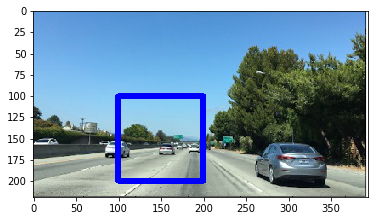

In [10]:
image = mpimg.imread('bbox-example-image.jpg')

# Define a function that takes an image, a list of bounding boxes, 
# and optional color tuple and line thickness as inputs
# then draws boxes in that color on the output


# Add bounding boxes in this format, these are just example coordinates.
#bboxes = [((100, 100), (200, 200)), ((300, 300), (400, 400))]

# Here are the bounding boxes I used
bboxes = [((275, 572), (380, 510)), ((488, 563), (549, 518)), ((554, 543), (582, 522)), 
          ((601, 555), (646, 522)), ((657, 545), (685, 517)), ((849, 678), (1135, 512))]

bboxes = [((100, 100), (200, 200)), ((300, 300), (400, 400))]
result = draw_boxes(image, bboxes)
plt.imshow(result)


## Template Matching
Template Matching

In [11]:
# Define a function to search for template matches
# and return a list of bounding boxes
def find_matches(img, template_list):
    # Define an empty list to take bbox coords
    bbox_list = []
    # Define matching method
    # Other options include: cv2.TM_CCORR_NORMED', 'cv2.TM_CCOEFF', 'cv2.TM_CCORR',
    #         'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED'
    method = cv2.TM_CCOEFF_NORMED
    # Iterate through template list
    for temp in template_list:
        # Read in templates one by one
        tmp = mpimg.imread(temp)
        # Use cv2.matchTemplate() to search the image
        result = cv2.matchTemplate(img, tmp, method)
        # Use cv2.minMaxLoc() to extract the location of the best match
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        # Determine a bounding box for the match
        w, h = (tmp.shape[1], tmp.shape[0])
        if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
            top_left = min_loc
        else:
            top_left = max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)
        # Append bbox position to list
        bbox_list.append((top_left, bottom_right))
        # Return the list of bounding boxes
        
    return bbox_list


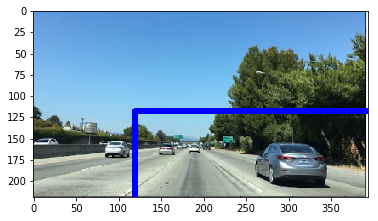

In [12]:
image = mpimg.imread('bbox-example-image.jpg')
#image = mpimg.imread('temp-matching-example-2.jpg')
templist = ['cutout1.jpg']#, 'cutout2.jpg', 'cutout3.jpg',
            #'cutout4.jpg', 'cutout5.jpg', 'cutout6.jpg']


bboxes = find_matches(image, templist)
result = draw_boxes(image, bboxes)
plt.imshow(result)

### Histograms of Color
color_histogram.py

In [13]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = None
    ghist = None
    bhist = None
    # Generating bin centers
    bin_centers = None
    # Concatenate the histograms into a single feature vector
    hist_features = None
    # Return the individual histograms, bin_centers and feature vectordef color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

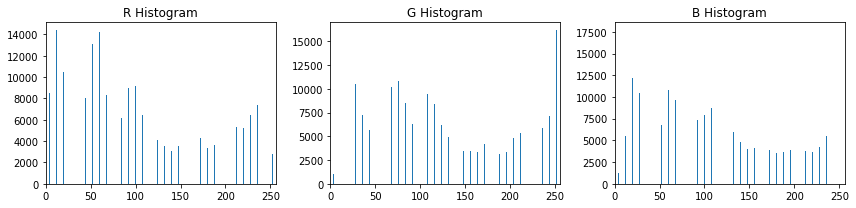

In [14]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread('cutout1.jpg')


    
rh, gh, bh, bincen, feature_vec = color_hist(image, nbins=32, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
else:
    print('Your function is returning None for at least one variable...')


### Spatial Binning of Color
spatial_bin.py

In [15]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
# KEEP IN MIND IF YOU DECIDE TO USE THIS FUNCTION LATER
# IN YOUR PROJECT THAT IF YOU READ THE IMAGE WITH 
# cv2.imread() INSTEAD YOU START WITH BGR COLOR!

# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

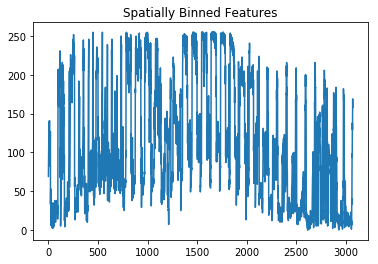

In [16]:


# Read in an image
# You can also read cutout2, 3, 4 etc. to see other examples
image = mpimg.imread('cutout1.jpg')
    
feature_vec = bin_spatial(image, color_space='RGB', size=(32, 32))

# Plot features
plt.plot(feature_vec)
plt.title('Spatially Binned Features')


### Data Exploration
For the exercises throughout the rest of this lesson, we'll use a relatively small labeled dataset to try out feature extraction and training a classifier. Before we get on to extracting HOG features and training a classifier, let's explore the dataset a bit. This dataset is a subset of the data you'll be starting with for the project.
There's no need to download anything at this point, but if you want to, you can download this subset of images for vehiclesand non-vehicles, or if you prefer you can directly grab the larger project dataset for vehicles and non-vehicles.
These datasets are comprised of images taken from the GTI vehicle image database, the KITTI vision benchmark suite, and examples extracted from the project video itself. In this exercise, you can explore the data to see what you're working with.
You are also welcome and encouraged to explore the recently released Udacity labeled dataset. Each of the Udacity datasets comes with a labels.csv file that gives bounding box corners for each object labeled.


car_notcar.py

In [17]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

In [18]:
"""
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
#from skimage.feature import hog
#from skimage import color, exposure
# images are divided up into vehicles and non-vehicles

#images = glob.glob('*.jpeg')
images = glob.glob(DIR_TRAIN_DATA)
cars = []
notcars = []

for image in images:
    #print(image)
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)

print(len(cars), len(notcars))
if (len(cars) != 0 and len(notcars) != 0) :
    data_info = data_look(cars, notcars)
else:
    print("Empty data")

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
"""


'\nimport matplotlib.image as mpimg\nimport matplotlib.pyplot as plt\nimport numpy as np\nimport cv2\nimport glob\n#from skimage.feature import hog\n#from skimage import color, exposure\n# images are divided up into vehicles and non-vehicles\n\n#images = glob.glob(\'*.jpeg\')\nimages = glob.glob(DIR_TRAIN_DATA)\ncars = []\nnotcars = []\n\nfor image in images:\n    #print(image)\n    if \'image\' in image or \'extra\' in image:\n        notcars.append(image)\n    else:\n        cars.append(image)\n\nprint(len(cars), len(notcars))\nif (len(cars) != 0 and len(notcars) != 0) :\n    data_info = data_look(cars, notcars)\nelse:\n    print("Empty data")\n\nprint(\'Your function returned a count of\', \n      data_info["n_cars"], \' cars and\', \n      data_info["n_notcars"], \' non-cars\')\nprint(\'of size: \',data_info["image_shape"], \' and data type:\', \n      data_info["data_type"])\n# Just for fun choose random car / not-car indices and plot example images   \ncar_ind = np.random.randint

In [19]:
def load_images(dir_path):
    images = glob.glob(dir_path)
    files = []
    for image in images:
        files.append(image)

    print(len(files))
    if (len(files) == 0) :
        print("Empty data")

    return files

8792
8968
8792 8968
Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


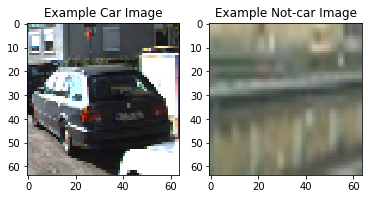

In [20]:
cars = load_images(DIR_TRAIN_DATA_VEHICLES)
notcars = load_images(DIR_TRAIN_DATA_NON_VEHICLES)

print(len(cars), len(notcars))
if (len(cars) != 0 and len(notcars) != 0) :
    data_info = data_look(cars, notcars)
else:
    print("Empty data")

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')


### scikit-image HOG


In [21]:
"""
solution.py
"""
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features


C:\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


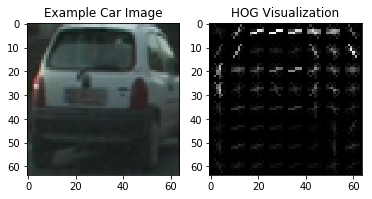

In [22]:
"""
get_hog.py
"""

# Read in our vehicles and non-vehicles
"""
images = glob.glob(DIR_TRAIN_DATA)
cars = []
notcars = []

for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
"""
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')


### Combine and Normalize Features

Norm_shuffle.py


In [23]:
"""
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
import glob

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features
"""

"\nimport numpy as np\nimport cv2\nimport matplotlib.pyplot as plt\nimport matplotlib.image as mpimg\nfrom sklearn.preprocessing import StandardScaler\nimport glob\n\n# Define a function to extract features from a list of images\n# Have this function call bin_spatial() and color_hist()\ndef extract_features(imgs, cspace='RGB', spatial_size=(32, 32),\n                        hist_bins=32, hist_range=(0, 256)):\n    # Create a list to append feature vectors to\n    features = []\n    # Iterate through the list of images\n    for file in imgs:\n        # Read in each one by one\n        image = mpimg.imread(file)\n        # apply color conversion if other than 'RGB'\n        if cspace != 'RGB':\n            if cspace == 'HSV':\n                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)\n            elif cspace == 'LUV':\n                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)\n            elif cspace == 'HLS':\n                feature_image = cv2.cvtColor(image,

In [24]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [25]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, 
                        hist_range=None,
                        orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            if hist_range == None:
                 hist_features = color_hist(feature_image, nbins=hist_bins)
            else:
                # Apply color_hist() also with a color space option now
                hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

C:\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


8792
8968


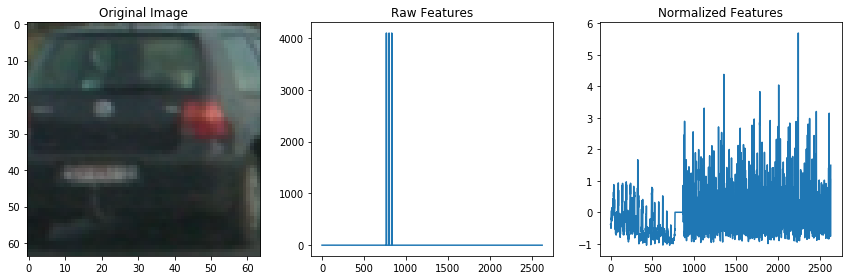

In [26]:

"""
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features
"""

"""
images = glob.glob(DIR_TRAIN_DATA)
cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
 """       
car_features = extract_features(cars, color_space='RGB',#cspace='RGB', 
                                spatial_size=(16, 16),#spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
notcar_features = extract_features(notcars, color_space='RGB',#cspace='RGB', 
                                   spatial_size=(16, 16),#spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
"""
print(len(car_features))
print(len(notcar_features))

len_car_features = len(car_features)
len_not_car_features = len(notcar_features)

if len_car_features > len_not_car_features :
    car_features = car_features[:len_not_car_features]
elif len_not_car_features < len_car_features :
    notcar_features = notcar_features[:len_car_features]
"""
print(len(car_features))
print(len(notcar_features))
                                           
if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')


### Parameter Tuning

Parameter Tuning
SVM Hyperparameters
In the SVM lesson, Katie mentioned optimizing the Gamma and C parameters.
Successfully tuning your algorithm involves searching for a kernel, a gamma value and a C value that minimize prediction error. To tune your SVM vehicle detection model, you can use one of scikit-learn's parameter tuning algorithms.
When tuning SVM, remember that you can only tune the C parameter with a linear kernel. For a non-linear kernel, you can tune C and gamma.
Parameter Tuning in Scikit-learn
Scikit-learn includes two algorithms for carrying out an automatic parameter search:
•	GridSearchCV
•	RandomizedSearchCV
GridSearchCV exhaustively works through multiple parameter combinations, cross-validating as it goes. The beauty is that it can work through many combinations in only a couple extra lines of code.
For example, if I input the values C:[0.1, 1, 10] and gamma:[0.1, 1, 10], gridSearchCV will train and cross-validate every possible combination of (C, gamma): (0.1, 0.1), (0.1, 1), (0.1, 10), (1, .1), (1, 1), etc.
RandomizedSearchCV works similarly to GridSearchCV except RandomizedSearchCV takes a random sample of parameter combinations. RandomizedSearchCV is faster than GridSearchCV since RandomizedSearchCV uses a subset of the parameter combinations.
Cross-validation with GridSearchCV
GridSearchCV uses 3-fold cross validation to determine the best performing parameter set. GridSearchCV will take in a training set and divide the training set into three equal partitions. The algorithm will train on two partitions and then validate using the third partition. Then GridSearchCV chooses a different partition for validation and trains with the other two partitions. Finally, GridSearchCV uses the last remaining partition for cross-validation and trains with the other two partitions.
By default, GridSearchCV uses accuracy as an error metric by averaging the accuracy for each partition. So for every possible parameter combination, GridSearchCV calculates an accuracy score. Then GridSearchCV will choose the parameter combination that performed the best.
Scikit-learn Cross Validation Example
Here's an example from the sklearn documentation for implementing GridSearchCV:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svr = svm.SVC()
clf = grid_search.GridSearchCV(svr, parameters)
clf.fit(iris.data, iris.target)
Let's break this down line by line.

parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]} 
A dictionary of the parameters, and the possible values they may take. In this case, they're playing around with the kernel (possible choices are 'linear' and 'rbf'), and C (possible choices are 1 and 10).
Then a 'grid' of all the following combinations of values for (kernel, C) are automatically generated:
('rbf', 1)	('rbf', 10)
('linear', 1)	('linear', 10)
Each is used to train an SVM, and the performance is then assessed using cross-validation.
svr = svm.SVC() 
This looks kind of like creating a classifier, just like we've been doing since the first lesson. But note that the "clf" isn't made until the next line--this is just saying what kind of algorithm to use. Another way to think about this is that the "classifier" isn't just the algorithm in this case, it's algorithm plus parameter values. Note that there's no monkeying around with the kernel or C; all that is handled in the next line.
clf = grid_search.GridSearchCV(svr, parameters) 
This is where the first bit of magic happens; the classifier is being created. We pass the algorithm (svr) and the dictionary of parameters to try (parameters) and it generates a grid of parameter combinations to try.
clf.fit(iris.data, iris.target) 
And the second bit of magic. The fit function now tries all the parameter combinations, and returns a fitted classifier that's automatically tuned to the optimal parameter combination. You can now access the parameter values via clf.best_params_.


### Color Classify

In [27]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
"""


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features
"""

C:\Anaconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


"\n\n\n# Define a function to extract features from a list of images\n# Have this function call bin_spatial() and color_hist()\ndef extract_features(imgs, cspace='RGB', spatial_size=(32, 32),\n                        hist_bins=32, hist_range=(0, 256)):\n    # Create a list to append feature vectors to\n    features = []\n    # Iterate through the list of images\n    for file in imgs:\n        # Read in each one by one\n        image = mpimg.imread(file)\n        # apply color conversion if other than 'RGB'\n        if cspace != 'RGB':\n            if cspace == 'HSV':\n                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)\n            elif cspace == 'LUV':\n                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)\n            elif cspace == 'HLS':\n                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)\n            elif cspace == 'YUV':\n                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)\n        else: feature_image = np

In [28]:
"""
# Read in car and non-car images
images = glob.glob(DIR_TRAIN_DATA)
cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
"""
# TODO play with these values to see how your classifier
# performs under different binning scenarios
spatial = 32
histbin = 32

car_features = extract_features(cars, color_space='RGB',#cspace='RGB', 
                                spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))
notcar_features = extract_features(notcars, color_space='RGB',#cspace='RGB', 
                        spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

C:\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 4932
23.73 Seconds to train SVC...
Test Accuracy of SVC =  0.971
My SVC predicts:  [ 0.  1.  1.  0.  1.  1.  1.  1.  1.  0.]
For these 10 labels:  [ 0.  1.  1.  0.  1.  1.  1.  1.  1.  0.]
0.00301 Seconds to predict 10 labels with SVC


### HOG Classify

In [29]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
"""
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


"""

'\n# Define a function to return HOG features and visualization\ndef get_hog_features(img, orient, pix_per_cell, cell_per_block, \n                        vis=False, feature_vec=True):\n    # Call with two outputs if vis==True\n    if vis == True:\n        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),\n                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, \n                                  visualise=vis, feature_vector=feature_vec)\n        return features, hog_image\n    # Otherwise call with one output\n    else:      \n        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),\n                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, \n                       visualise=vis, feature_vector=feature_vec)\n        return features\n\n\n'

In [30]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features_hog(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [31]:
# Divide up into cars and notcars
"""
images = glob.glob(DIR_TRAIN_DATA)
cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
"""
# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
sample_size = 500
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features_hog(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features_hog(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')


C:\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


3.33 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 1764
0.08 Seconds to train SVC...
Test Accuracy of SVC =  0.995
My SVC predicts:  [ 1.  0.  1.  1.  1.  1.  1.  0.  1.  1.]
For these 10 labels:  [ 1.  0.  1.  1.  1.  1.  1.  0.  1.  1.]
0.002 Seconds to predict 10 labels with SVC


### Sliding Window Implementation
Sliding_window.py


In [32]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread('bbox-example-image.jpg')

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=(None, None), y_start_stop=(None, None), 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    # Compute the span of the region to be searched    
    # Compute the number of pixels per step in x/y
    # Compute the number of windows in x/y
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, so looping makes sense
        # Calculate each window position
        # Append window position to list
    # Return the list of windows
    return window_list
"""
solution.py
"""
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

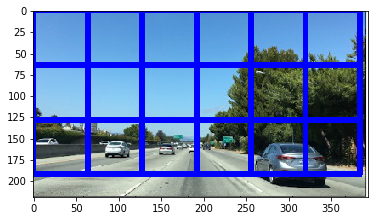

In [33]:
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], #x_start_stop=(None, None), y_start_stop=(None, None), 
                     xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                    #xy_window=[128, 128], xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

### Search and Classify
Search_classify.py


lesson_function.py

In [34]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [35]:
"""
mport matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

"""

'\nmport matplotlib.image as mpimg\nimport numpy as np\nimport cv2\nfrom skimage.feature import hog\n# Define a function to return HOG features and visualization\ndef get_hog_features(img, orient, pix_per_cell, cell_per_block, \n                        vis=False, feature_vec=True):\n    # Call with two outputs if vis==True\n    if vis == True:\n        features, hog_image = hog(img, orientations=orient, \n                                  pixels_per_cell=(pix_per_cell, pix_per_cell),\n                                  cells_per_block=(cell_per_block, cell_per_block), \n                                  transform_sqrt=True, \n                                  visualise=vis, feature_vector=feature_vec)\n        return features, hog_image\n    # Otherwise call with one output\n    else:      \n        features = hog(img, orientations=orient, \n                       pixels_per_cell=(pix_per_cell, pix_per_cell),\n                       cells_per_block=(cell_per_block, cell_per_block), \n  

In [36]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
##from lesson_functions import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [37]:
"""
solution.py
"""
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


### Features Extraction

In [38]:
# Read in cars and notcars
"""
images = glob.glob(DIR_TRAIN_DATA)
cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
"""
# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
#sample_size = 500
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
color_space = 'HLS' #'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" #0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32 #16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()



C:\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6156
0.21 Seconds to train SVC...
Test Accuracy of SVC =  0.995


In [50]:
image = mpimg.imread('bbox-example-image.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
if TRAINING_IMAGE_SUFFIX == IMAGE_SUFFIX_PNG:
    image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

print(hot_windows)

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

error: ..\..\..\modules\imgproc\src\imgwarp.cpp:3229: error: (-215) ssize.area() > 0 in function cv::resize


In [40]:
def prit_parameters(color_space, 
                        spatial_size, hist_bins, 
                        orient, pix_per_cell, 
                        cell_per_block,
                        hog_channel, spatial_feat, 
                        hist_feat, hog_feat):
    print("color_space",color_space) 

    print("hist_bins",hist_bins) 
    print("orient",orient)
    print("pix_per_cell",pix_per_cell) 
    print("cell_per_block",cell_per_block)
    print("hog_channel",hog_channel) 
    print("spatial_feat",spatial_feat) 
    print("spatial_size",spatial_size)
    print("hist_feat",hist_feat)
    print("hog_feat",hog_feat)

(64, 64) [360, 503]
(128, 128) [360, 576]
(256, 256) [360, 720]


C:\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


color_space HLS
hist_bins 32
orient 9
pix_per_cell 8
cell_per_block 2
hog_channel ALL
spatial_feat True
spatial_size (16, 16)
hist_feat True
hog_feat True


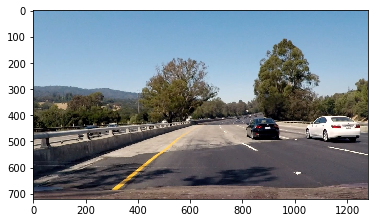

In [41]:
SIZE_RANGES = (64, 128, 256)
Y_END_RATES = (0.7, 0.8, 1)
XY_OVERLAP = (0.7, 0.7)

image = mpimg.imread('test_images/test4.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
if TRAINING_IMAGE_SUFFIX == IMAGE_SUFFIX_PNG:
    image = image.astype(np.float32)/255

x_start_stop = [None, None]
y_start_stop = [image.shape[0]//2, image.shape[0]]

windows = []
for y_end, xysize in zip(Y_END_RATES, SIZE_RANGES):
    size = (xysize, xysize)
    y_start_stop = [image.shape[0]//2, int(y_end*image.shape[0])]
    windows.extend(slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=size, xy_overlap=XY_OVERLAP))

    print(size, y_start_stop)

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)  

prit_parameters(color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

### Multiple Detections & False Positives

In [42]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

### Heat Map

image was modified.
(64, 64) [360, 503]
(128, 128) [360, 576]
(256, 256) [360, 720]


C:\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


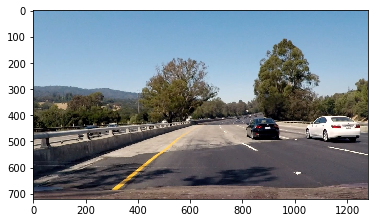

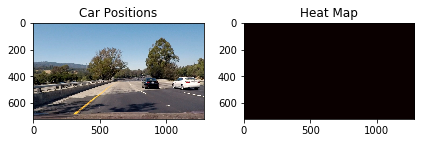

In [43]:
# Read in image similar to one shown above 
#image = mpimg.imread("bbox-example-image.jpg")#('test_image.jpg')
image = mpimg.imread('test_images/test4.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
search_image = np.copy(image)
if TRAINING_IMAGE_SUFFIX == IMAGE_SUFFIX_PNG:
    print("image was modified.")
    search_image = search_image.astype(np.float32)/255

x_start_stop = [None, None]
y_start_stop = [image.shape[0]//2, image.shape[0]]

windows = []
for y_end, xysize in zip(Y_END_RATES, SIZE_RANGES):
    size = (xysize, xysize)
    y_start_stop = [image.shape[0]//2, int(y_end*image.shape[0])]
    windows.extend(slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=size, xy_overlap=XY_OVERLAP))

    print(size, y_start_stop)

hot_windows = search_windows(search_image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)  


#box_list = pickle.load( open( "bbox_pickle.p", "rb" ))
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

heat = np.zeros_like(image[:,:,0]).astype(np.float)


# Add heat to each box in box list
heat = add_heat(heat,hot_windows)#ox_list)

print(heat)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

In [44]:
def process_search(image):
    search_image = np.copy(image)
    if TRAINING_IMAGE_SUFFIX == IMAGE_SUFFIX_PNG:
        search_image = search_image.astype(np.float32)/255
    
    hot_windows = search_windows(search_image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)  
    # ignore heatmap
    draw_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6)  
    return draw_img

def process_heatmap(image):
    search_image = np.copy(image)
    if TRAINING_IMAGE_SUFFIX == IMAGE_SUFFIX_PNG:
        search_image = search_image.astype(np.float32)/255
    
    hot_windows = search_windows(search_image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)  

    #draw_img = np.copy(image)

    heat = np.zeros_like(image[:,:,0]).astype(np.float)


    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    return draw_img

C:\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


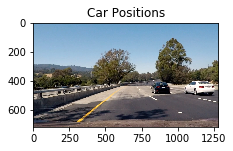

In [47]:
image = mpimg.imread('test_images/test4.jpg')
# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)

#if TRAINING_IMAGE_SUFFIX == IMAGE_SUFFIX_PNG:
#    image = image.astype(np.float32)/255
        
#draw_img = process_heatmap(image)
draw_img = process_search(image)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
#plt.subplot(122)
#plt.imshow(heatmap, cmap='hot')
#plt.title('Heat Map')
fig.tight_layout()

In [46]:
print("Preperation Completed")

Preperation Completed


# End of Preparation



# -------------------------------------------------------------------
### Hog Sub-sampling Window Search
Hog_subsample.py


In [ ]:

"""
lesson_function.py
"""
import numpy as np
import cv2
from skimage.feature import hog

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
#from lesson_functions import *



# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img

In [ ]:
#dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
#svc = dist_pickle["svc"]
#X_scaler = dist_pickle["scaler"]
#orient = dist_pickle["orient"]
#pix_per_cell = dist_pickle["pix_per_cell"]
#cell_per_block = dist_pickle["cell_per_block"]
#spatial_size = dist_pickle["spatial_size"]
#hist_bins = dist_pickle["hist_bins"]

#img = mpimg.imread('test_image.jpg')
img = mpimg.imread('cutout1.jpg')

img = mpimg.imread("test1.jpg")
img = mpimg.imread("./test_images/test1.jpg")

ystart = 400
ystop = 656
scale = 1.5
    
out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)

In [ ]:
# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
"""
#box_list = pickle.load( open( "bbox_pickle.p", "rb" ))

# Read in image similar to one shown above 
image = mpimg.imread("bbox-example-image.jpg")#('test_image.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
"""

In [ ]:


# Read in image similar to one shown above 
#image = mpimg.imread("bbox-example-image.jpg")#('test_image.jpg')
image = mpimg.imread('test_images/test4.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
if TRAINING_IMAGE_SUFFIX == IMAGE_SUFFIX_PNG:
    print("image was modified.")
    image = image.astype(np.float32)/255

x_start_stop = [None, None]
y_start_stop = [image.shape[0]//2, image.shape[0]]

windows = []
for y_end, xysize in zip(Y_END_RATES, SIZE_RANGES):
    size = (xysize, xysize)
    y_start_stop = [image.shape[0]//2, int(y_end*image.shape[0])]
    windows.extend(slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=size, xy_overlap=XY_OVERLAP))

    print(size, y_start_stop)

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)  


#box_list = pickle.load( open( "bbox_pickle.p", "rb" ))


heat = np.zeros_like(image[:,:,0]).astype(np.float)


# Add heat to each box in box list
heat = add_heat(heat,hot_windows)#ox_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

### Histogram of Oriented Gradients (HOG)

### Clarification

lesson function.py

In [ ]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

search classify.py

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
#from lesson_functions import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [ ]:
"""
Solution.py
"""
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

#### Execution with sample images

In [ ]:
def process_image(image, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat):
    draw_image = np.copy(image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    if TRAINING_IMAGE_SUFFIX == IMAGE_SUFFIX_PNG:
        image = image.astype(np.float32)/255

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(96, 96), xy_overlap=(0.5, 0.5))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)  
    # just a test
    #window_img = draw_boxes(draw_image, windows, color=(0, 0, 255), thick=6)  
    return window_img


In [ ]:
def train():
    images = glob.glob(DIR_TRAIN_DATA)
    cars = []
    notcars = []
    for image in images:
        #print(image)
        if 'image' in image or 'extra' in image:
            notcars.append(image)
        else:
            cars.append(image)

    # Reduce the sample size because
    # The quiz evaluator times out after 13s of CPU time
    sample_size = 500
    cars = cars[0:sample_size]
    notcars = notcars[0:sample_size]

    ### TODO: Tweak these parameters and see how the results change.
    color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 0 # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 16    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off
    y_start_stop = [None, None] # Min and max in y to search in slide_window()

    car_features = extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

    print("car_features",len(car_features))
    print("notcar_features",len(notcar_features))

    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    
    return svc, X_scaler

In [ ]:
# Read in cars and notcars
"""
images = glob.glob(DIR_TRAIN_DATA)
cars = []
notcars = []
for image in images:
    #print(image)
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)

# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
sample_size = 500
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print("car_features",len(car_features))
print("notcar_features",len(notcar_features))

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
"""
image = mpimg.imread('bbox-example-image.jpg')
"""
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
if TRAINING_IMAGE_SUFFIX == IMAGE_SUFFIX_PNG:
    image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)  
# just a test
#window_img = draw_boxes(draw_image, windows, color=(0, 0, 255), thick=6)   
"""
svc, X_scaler = train()
window_img = process_image(image, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)       

plt.imshow(window_img)

### Function Definition

In [ ]:
def init_classifier():
    return null

In [ ]:
def mark_image(image, bboxes):
    process_image = image.copy()
    return process_image

### Class Definition

In [ ]:
class VideoProcessor:
    def __int__(self, frame_size=0):
        self.__FRAME_FACTOR = 0.3
        self.__NB_AVG_FRAMES = 5
        
        self.heatmap = np.zeros(frame_size)
        self.frames = []
        self.frame_size = frame_size
        self.svm_classifier = init_classifier()
    def init_classifier():
        
    def get_frame_size(frame):
        
    def process_frame(frame):
        # TODO
        if (self.frame_size == 0):
            self.frame_size = get_frame_size(frame)
        
        # using heatmap
        self.heatmap = self.__FRAME_FACTOR * frame + (1-self.__FRAME_FACTOR) * self.heatmap
        # do threshold and some kind of detection (blob or cv.contours)

        # using averaged frame
        self.frames.append(frame)
        avg_frame = np.mean(np.array(self.frames)[-self.__NB_AVG_FRAMES], axis=-1)

        # TODO: do more stuff
        return proccessed_frame
        

### Class Definition

In [ ]:
class Classifier():
    def __init__(self):
        self.svm_classifier = init_classifier()
    def classify(self, image):
        return np.array([])

## Video Implementation

In [51]:
DIR_ORG_VIDEO_SHOT = "./video_images/"
DIR_CVT_VIDEO_SHOT = "./converted_images/"
ORG_VIDEO_FILE_NAME = "org_video_image_"
CVT_VIDEO_FILE_NAME = "cvt_video_image_"
from PIL import Image
def save_image(image, dirname, filename):
    """save a image file"""    
    filepath = dirname + filename + datetime.now().strftime("%Y%m%d_%H_%M_%S.jpg")
    if not os.path.exists(filepath) :
        Image.fromarray(image).save(filepath)

In [52]:
classifier = None

In [59]:
from datetime import datetime
import os
def video_pipeline(image):
    import __main__
    #if __main__.classifier == None:
    #    __main__.classifier = Classifier()
    
    #detected = __main__.classifier.classify(image)
    #save_image(image,DIR_ORG_VIDEO_SHOT, ORG_VIDEO_FILE_NAME)
    
    #processed_image = np.copy(image)

    processed_image = process_heatmap(image)#, detected)
    
    return processed_image # This must be a color image

In [60]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = video_pipeline(image)
    return result

In [61]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [62]:
VIDEO_INPUT = 'test_video.mp4'
VIDEO_OUTPUT = 'output_images/test_video_output.mp4'

In [63]:
VIDEO_INPUT = 'project_video.mp4'
VIDEO_OUTPUT = 'output_images/project_video_output.mp4'

In [64]:
#VIDEO_INPUT = 'project_video.mp4'
#VIDEO_OUTPUT = 'output_images/project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

#videoProcessor = VideoProcessor()

clip1 = VideoFileClip(VIDEO_INPUT)
#white_clip = clip1.fl_image(process_search)#process_heatmap)#videoProcessor.process_frame)#process_image) #NOTE: this function expects color images!!
white_clip = clip1.fl_image(video_pipeline)#process_heatmap)#videoProcessor.process_frame)#process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(VIDEO_OUTPUT, audio=False)
flg_in_process = False
left_fit = None
right_fit = None

[MoviePy] >>>> Building video output_images/project_video_output.mp4
[MoviePy] Writing video output_images/project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [07:28<00:00,  2.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_output.mp4 

Wall time: 7min 30s


In [65]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(VIDEO_OUTPUT))

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(VIDEO_INPUT))